# <span style="font-size:1.5em;"> Forecasting Air Quality in New York City
Author: Angela Kim

---

# <span style="font-size:1.2em;"> Contents

<span style="font-size:1.2em;">

- <a href="#Overview">Overview</a>
    
- <a href="#Business Problem">Business Problem</a>
    
- <a href="#Imports">Library Imports & Functions</a>

- <a href="#Data Preparation & Analysis">Data Preparation & Analysis</a>
    
- <a href="#Modeling">Modeling</a>

- <a href="#Visualizations">Visualizations</a>
    
- <a href="#Conclusion">Conclusion</a>

- <a href="#Next Steps">Next Steps</a>

---

# <span style="font-size:1.2em;"> <a id="Overview">Overview</a>

> This project analyzes air pollution data of four major gas pollutants--ground-level ozone (O₃), carbon monoxide (CO), nitrogen dioxide (NO₂), and sulfur dioxide (SO₂)--and creates time series models to forecast future air quality in New York City.
>
> Note: For ease of reference, I will use O3, CO, NO2, and SO2 when naming the pollutants, knowing full well that technically they are not accurate chemical formulas.

# <span style="font-size:1.2em;"> <a id="Business Problem">Business Problem</a>

> Air pollution is a huge problem for everyone. According to the Environmental Defense Fund (EDF), air pollution is currently the biggest environmental risk of premature death. It is highly linked to cardiovascular and respiratory disease and worsens symptoms of susceptible populations.
>
> Not only is air pollution bad for public health, it’s also bad for the economy. Air pollution costs the US roughly 5% of its annual GDP in damages ($790 billion in 2014). The highest costs come from premature deaths. A study by Anthony Heyes, Matthew Neidell, and Soodeh Saberian even suggests that air pollution affects the stock market.
>
> Air pollution also exacerbates the race-class divide. Racial and ethnic minorities are exposed to higher levels of air pollution, especially in highly segregated neighborhoods. Urban areas are more polluted than rural areas, which is where there are denser populations of minorities.
>
> Decreasing air pollution would benefit public health and the economy and contribute to a more equitable society.

# <span style="font-size:1.2em;"> <a id="Imports">Library Imports & Functions</a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import itertools
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA, ARIMA, ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Functions for EDA

def stationarity_check(df, pollutant):
    """
    Checks stationarity of time series with rolling statistics and Dickey-Fuller test.
    """
    rmean = df.rolling(window=12, center=False).mean()
    rstd = df.rolling(window=12, center=False).std()
    dftest = adfuller(df.iloc[:,0])
    
    # Plot rolling statistics against original
    fig = plt.figure(figsize=(20,4))
    plt.plot(df, color='gray', label='Original')
    plt.plot(rmean, color='blue', label='Rolling Mean')
    plt.plot(rstd, color='magenta', label='Rolling Std')
    plt.title(f'Rolling Mean & Standard Deviation ({pollutant})')
    plt.legend(loc='best')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4],
                         index=['Test Statistic', 'p-value', '# of Lags Used', '# of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None


""""""


def decomposition_plot(df):
        """
        Takes time series dataframe and decomposes it in order to observe trend, seasonality, and residuals.
        """
        decomp = seasonal_decompose(df, period=8, model='additive')
        trend = decomp.trend
        seasonal = decomp.seasonal
        residual = decomp.resid
        plt.figure(figsize=(10,7))
        plt.subplot(511)
        plt.plot(df, label='Observed', color='red')
        plt.legend(loc='best')
        plt.subplot(512)
        plt.plot(trend, label='Trend', color='blue')
        plt.legend(loc='best')
        plt.subplot(513)
        plt.plot(seasonal, label='Seasonality', color='orange')
        plt.legend(loc='best')
        plt.subplot(514)
        plt.plot(residual, label='Residuals', color='black')
        plt.legend(loc='best')
        plt.tight_layout()
        
        return decomp

In [3]:
# Functions for time series forecast metrics

def rmse(y_true, y_pred):
    """
    Computes Root Mean Squared Error (RMSE)
    """
    return mse(y_true, y_pred, squared=False) # Can't be bothered to specify "squared=False" each time



def mase(y_true, y_pred, y_train):
    """
    Computes Mean Absolute Scaled Error for univariate time series forecasts.
    *See "Another look at measures of forecast accuracy" | Rob J. Hyndman, Anne B. Koehler (2006)
    """
    e_t = y_true - y_pred
    scale = mean_absolute_error(y_train[1:], y_train[:-1])
    
    return np.mean(np.abs(e_t/scale))

In [4]:
def ARMA_model(df, pollutant):

    y = df[f'{pollutant} AQI']
    aic_scores = []
    train_size = [len(y),500,250,100,50]

    for p in range(6):
        for q in range(6):
            for size in train_size:
                model = ARIMA(endog = y.tail(size), order =(p,0,q))
                fitmodel = model.fit()
                rmse = np.sqrt(mse(fitmodel))
                aic_scores.append(pd.DataFrame(['ARMA', size, (p,0,q), fitmodel.aic, rmse]).T)
                    
    arma_df = pd.concat(aic_scores, axis = 0)
    arma_df.set_axis(['model type', 'train_size', 'order', 'AIC', 'RMSE'], axis = 1, inplace = True)
    return_df = arma_df.sort_values(['train_size','RMSE'], ascending = [False,True]).reset_index(drop = True)
    
    return return_df

# <span style="font-size:1.2em;"> <a id="Data Preparation & Analysis">Data Preparation & Analysis</a>

In [5]:
# Import datasets
O3 = pd.read_csv('data/nycO3.csv')
CO = pd.read_csv('data/nycCO.csv')
NO2 = pd.read_csv('data/nycNO2.csv')
SO2 = pd.read_csv('data/nycSO2.csv')

In [6]:
# Change date columns to datetime and set as index for time series
dflist = [O3, CO, NO2, SO2]

for df in dflist:
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index(['Date'], inplace=True)
    print(df.index.dtype)
    display(df.head())

datetime64[ns]


O3 AQI
Date              
2000-01-01      25
2000-01-02      38
2000-01-03      31
2000-01-04      29
2000-01-05      24

datetime64[ns]


CO AQI
Date              
2000-01-01    27.0
2000-01-02    36.0
2000-01-03    38.0
2000-01-04    33.0
2000-01-05    22.0

datetime64[ns]


NO2 AQI
Date               
2000-01-01       38
2000-01-02       54
2000-01-03       47
2000-01-04       52
2000-01-05       42

datetime64[ns]


SO2 AQI
Date               
2000-01-01    105.0
2000-01-02     79.0
2000-01-03     99.0
2000-01-04     82.0
2000-01-05     43.0

In [7]:
## Preparing dataframes for modeling

# Creating list of daily AQI per pollutant
dailys = []
for df in dflist:
    dailys.append(df.iloc[:])

# Downsampling from days to months
monthlyO3 = dailys[0].resample('M').mean()
monthlyCO = dailys[1].resample('M').mean()
monthlyNO2 = dailys[2].resample('M').mean()
monthlySO2 = dailys[3].resample('M').mean()

# Creating list of monthly AQI per pollutant
monthlys = [monthlyO3, monthlyCO, monthlyNO2, monthlySO2]


""""""


## Preparing dataframes for visualization


# Concatenating individual pollutant dataframes for visualizations
df = pd.merge(O3, CO, how='inner', left_index=True, right_index=True)
df = pd.merge(df, NO2, how='inner', left_index=True, right_index=True)
df = pd.merge(df, SO2, how='inner', left_index=True, right_index=True)

# Creating list of daily AQI per pollutant for visualizations
plot_dailys = [df['O3 AQI'], df['CO AQI'], df['NO2 AQI'], df['SO2 AQI']]

# Downsampling from days to months for visualizations
plot_monthlyO3 = df.copy()['O3 AQI'].resample('M').mean()
plot_monthlyCO = df.copy()['CO AQI'].resample('M').mean()
plot_monthlyNO2 = df.copy()['NO2 AQI'].resample('M').mean()
plot_monthlySO2 = df.copy()['SO2 AQI'].resample('M').mean()

# Creating list of monthly AQI per pollutant for visualizations
plot_monthlys = [plot_monthlyO3, plot_monthlyCO, plot_monthlyNO2, plot_monthlySO2]

# Check dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7944 entries, 2000-01-01 to 2021-09-30
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   O3 AQI   7944 non-null   int64  
 1   CO AQI   7944 non-null   float64
 2   NO2 AQI  7944 non-null   int64  
 3   SO2 AQI  7944 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 630.3 KB


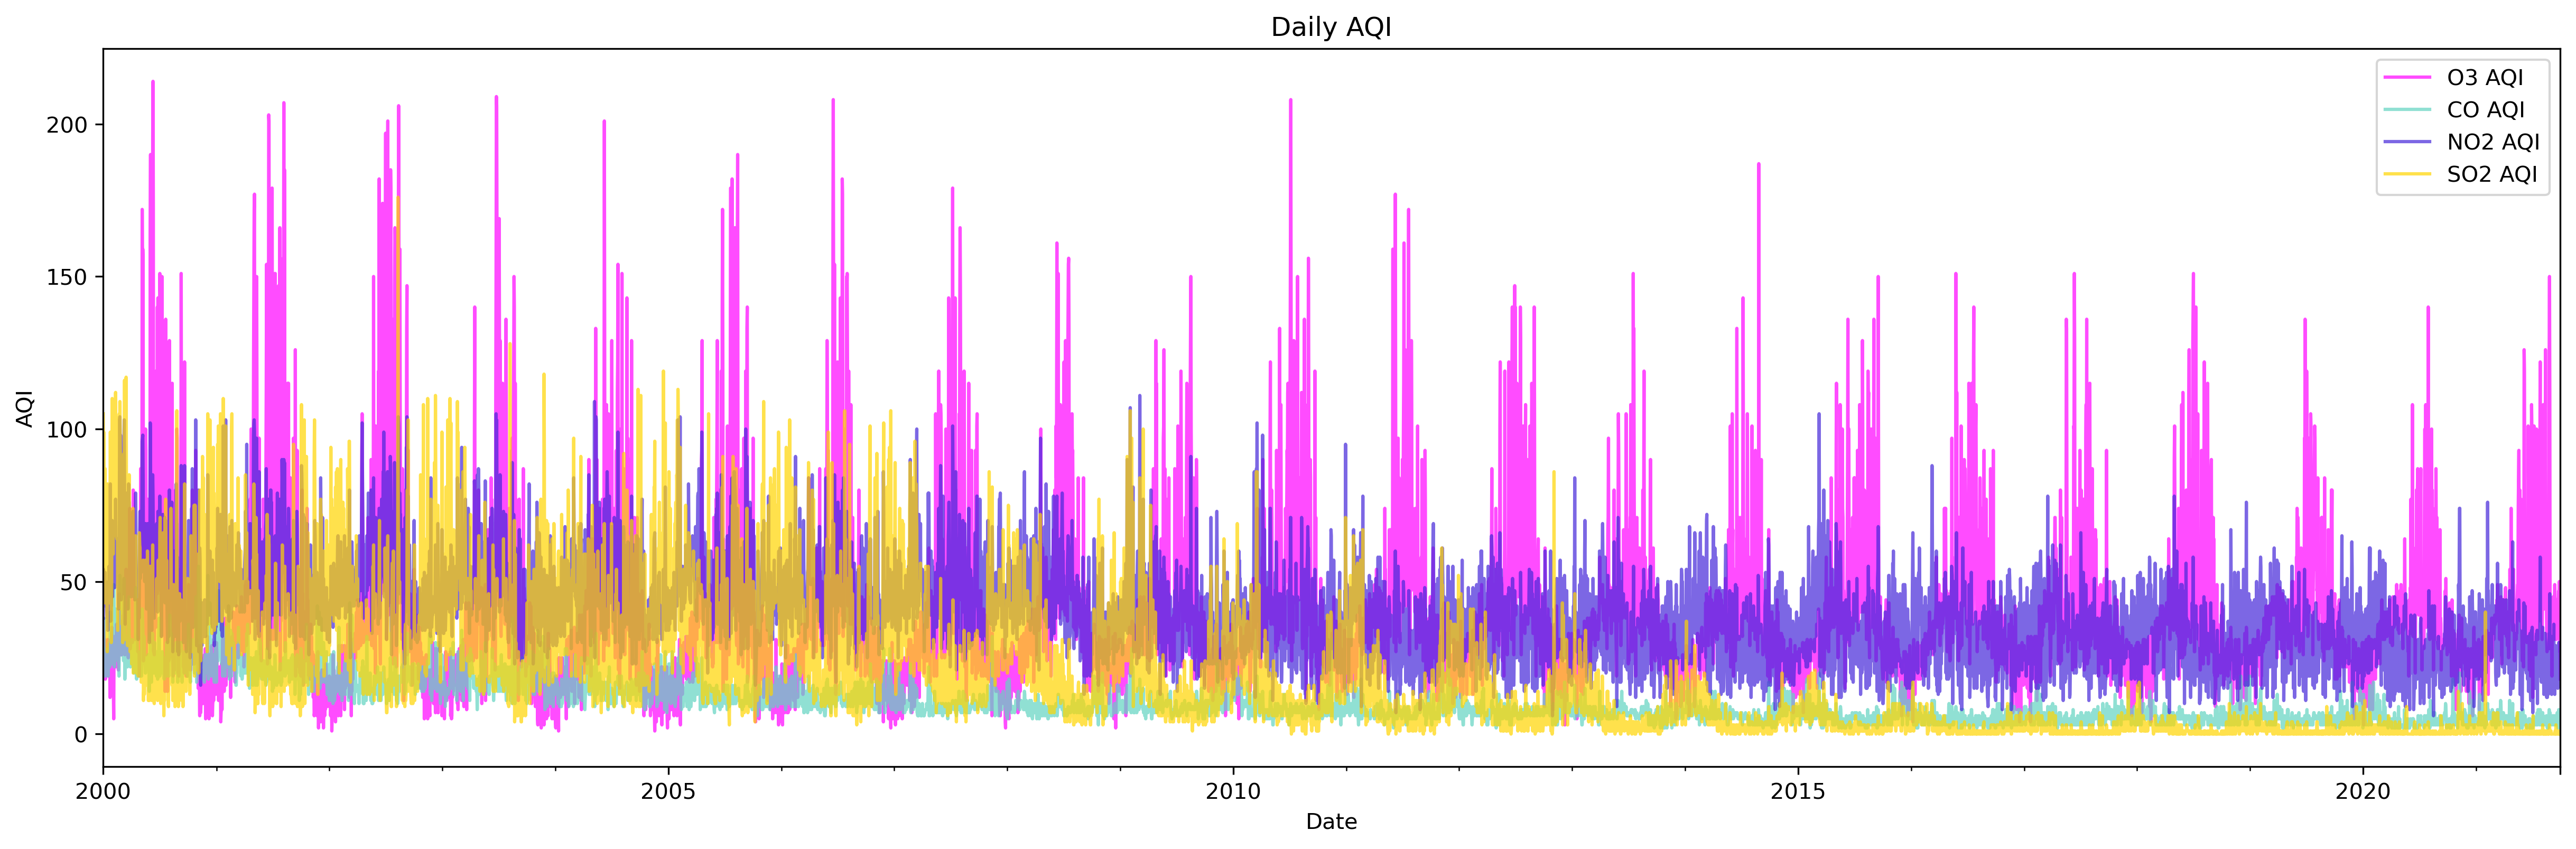

In [8]:
# Plotting daily AQI
plt.figure(figsize=(20,6), dpi=300)
plot_dailys[0].plot(color='magenta', alpha=0.7)
plot_dailys[1].plot(color='#61d4c1', alpha=0.7)
plot_dailys[2].plot(color='#4527d9', alpha=0.7)
plot_dailys[3].plot(color='#ffd500', alpha=0.7)
plt.title('Daily AQI')
plt.ylabel('AQI')
plt.legend();

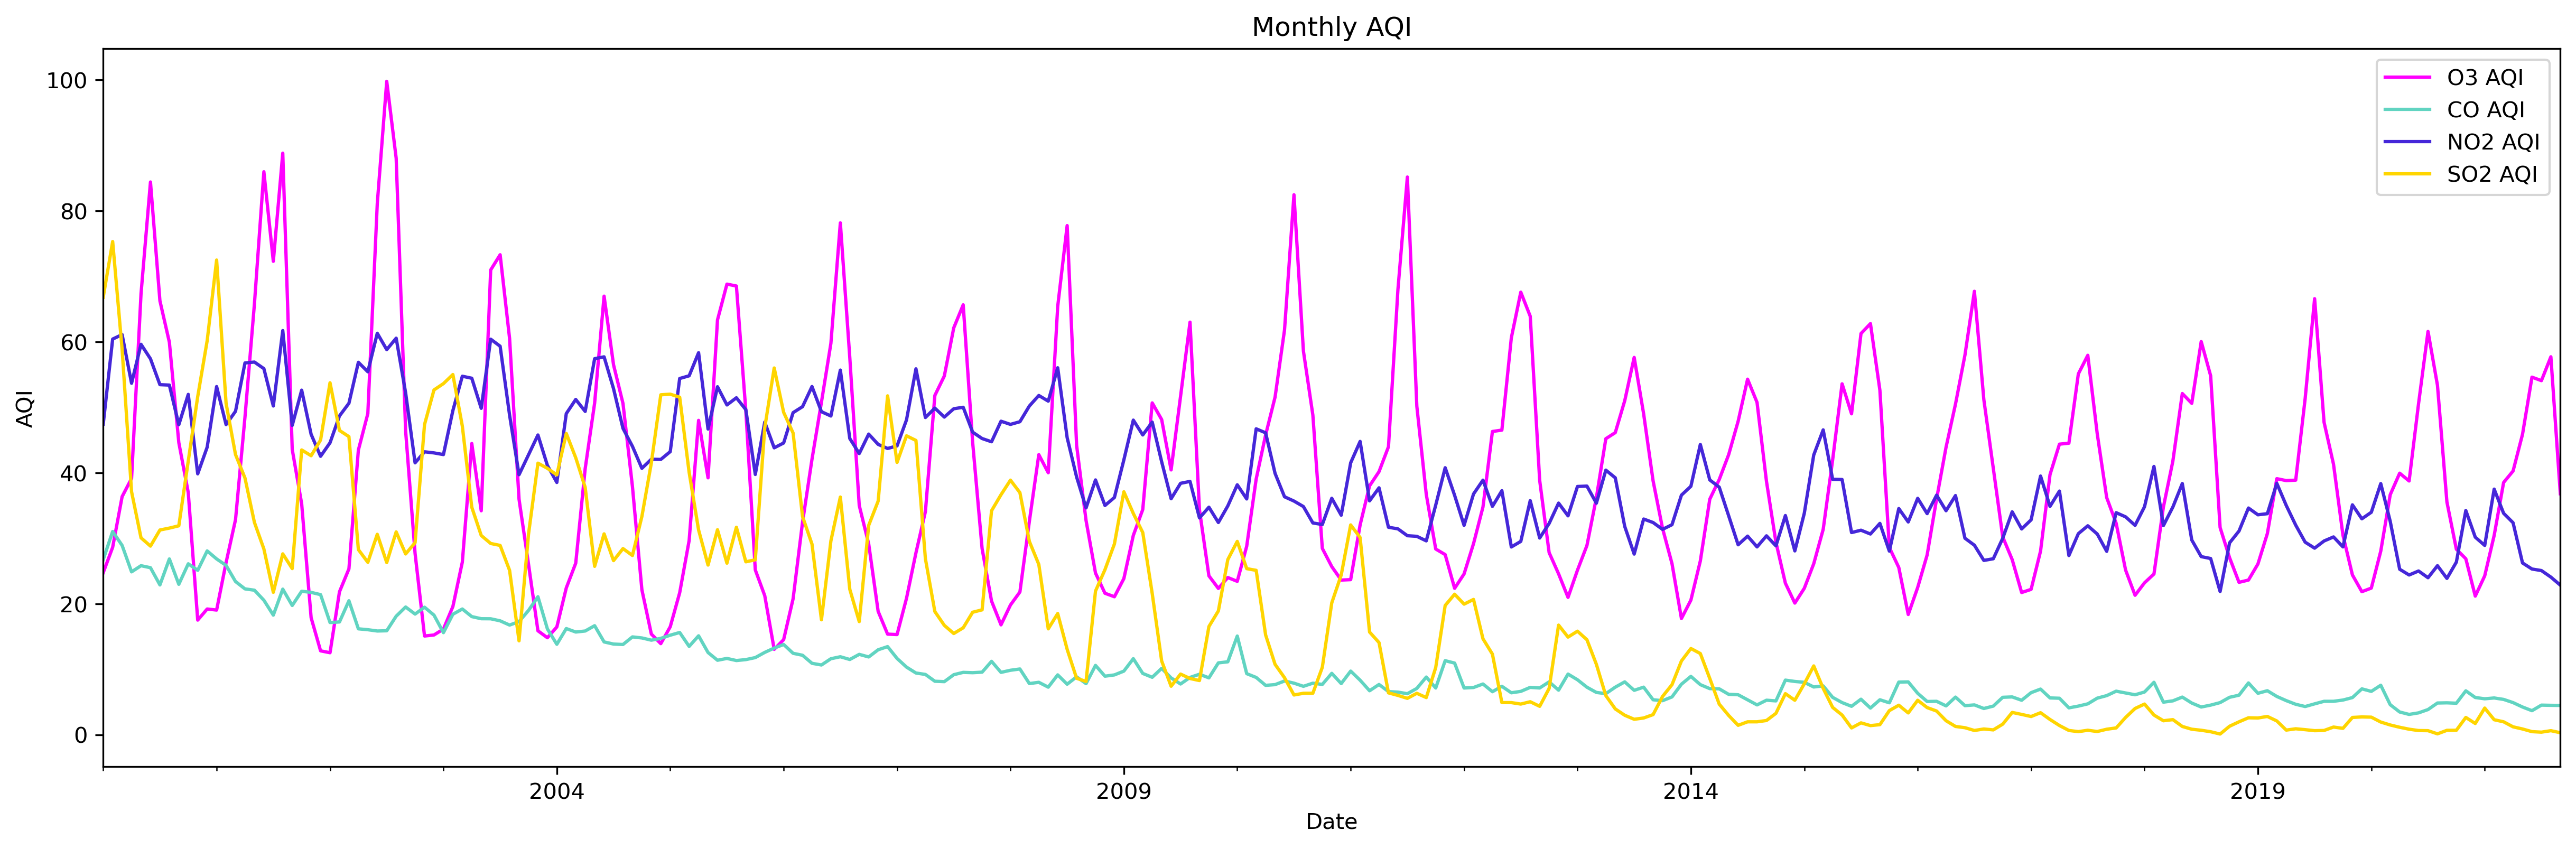

In [9]:
# Plotting monthly AQI
plt.figure(figsize=(20,6), dpi=300)
plot_monthlys[0].plot(color='magenta')
plot_monthlys[1].plot(color='#61d4c1')
plot_monthlys[2].plot(color='#4527d9')
plot_monthlys[3].plot(color='#ffd500')
plt.title('Monthly AQI')
plt.ylabel('AQI')
plt.legend();

In [10]:
# Daily AQI log
dailyO3_log = np.log(O3)
dailyCO_log = np.log(CO)
dailyNO2_log = np.log(NO2)
dailySO2_log = np.log(SO2)

In [11]:
daily_log = [dailyO3_log, dailyCO_log, dailyNO2_log, dailySO2_log]

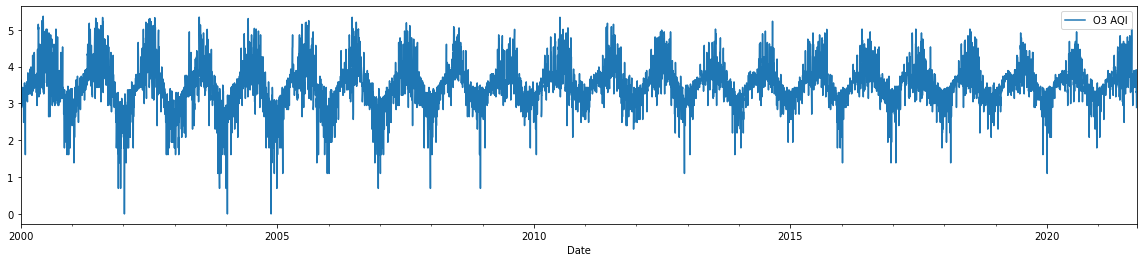

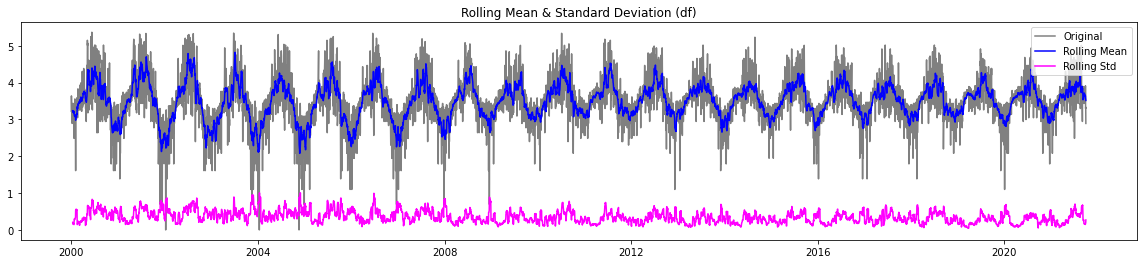

Results of Dickey-Fuller Test: 

Test Statistic           -5.808590e+00
p-value                   4.456040e-07
# of Lags Used            2.100000e+01
# of Observations Used    7.922000e+03
Critical Value (1%)      -3.431176e+00
Critical Value (5%)      -2.861905e+00
Critical Value (10%)     -2.566964e+00
dtype: float64


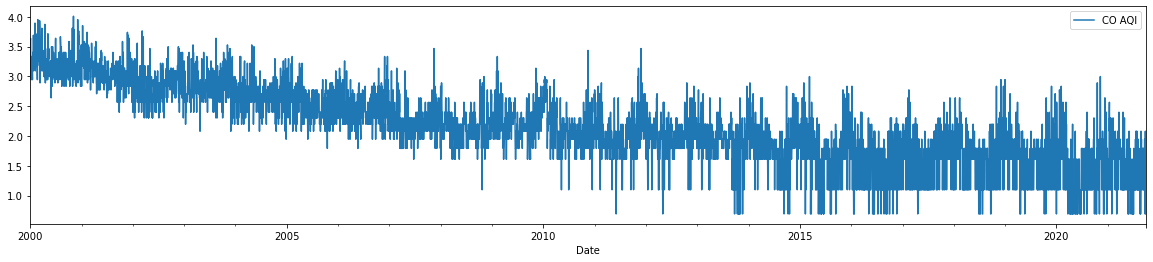

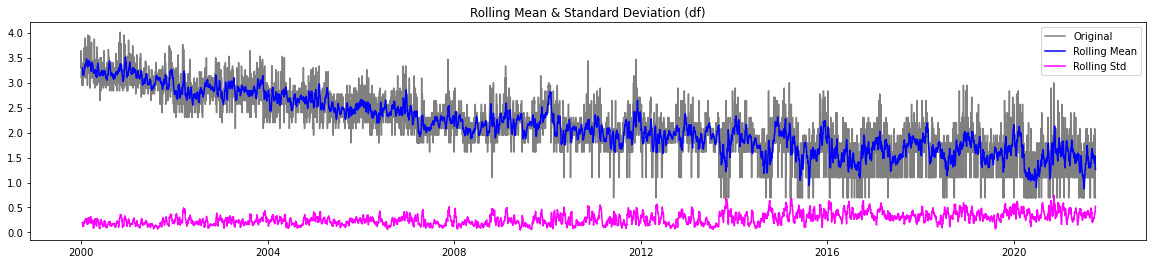

Results of Dickey-Fuller Test: 

Test Statistic              -2.705216
p-value                      0.073140
# of Lags Used              34.000000
# of Observations Used    7910.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861905
Critical Value (10%)        -2.566965
dtype: float64


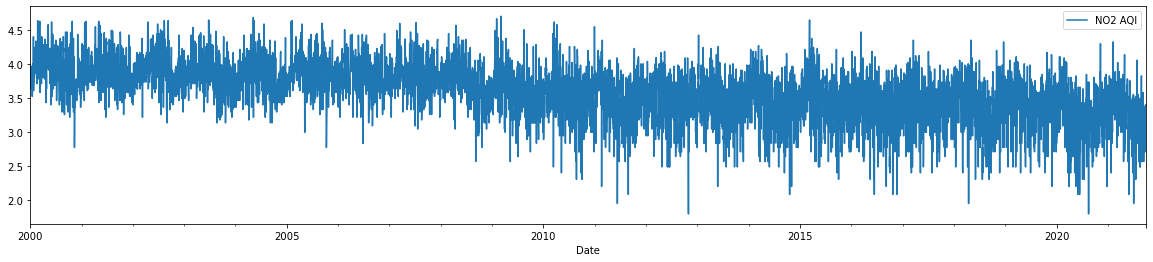

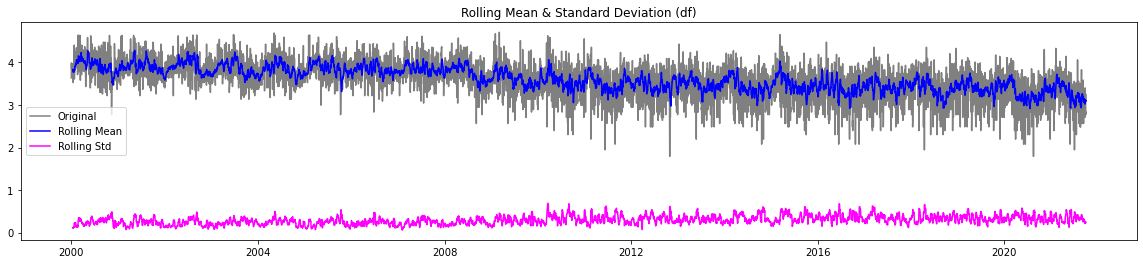

Results of Dickey-Fuller Test: 

Test Statistic              -4.165286
p-value                      0.000754
# of Lags Used              34.000000
# of Observations Used    7909.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861906
Critical Value (10%)        -2.566965
dtype: float64


MissingDataError: exog contains inf or nans

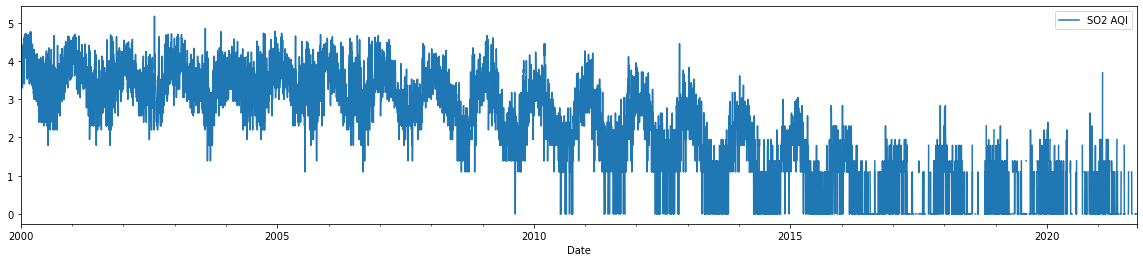

In [12]:
for df in daily_log:
    df.plot(figsize=(20,4))
    stationarity_check(df, 'df')

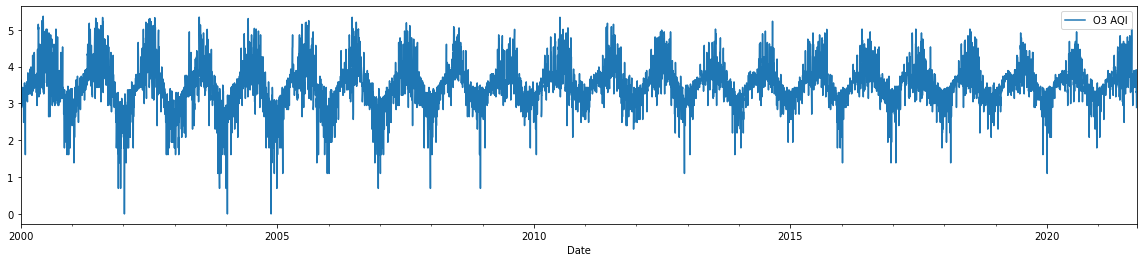

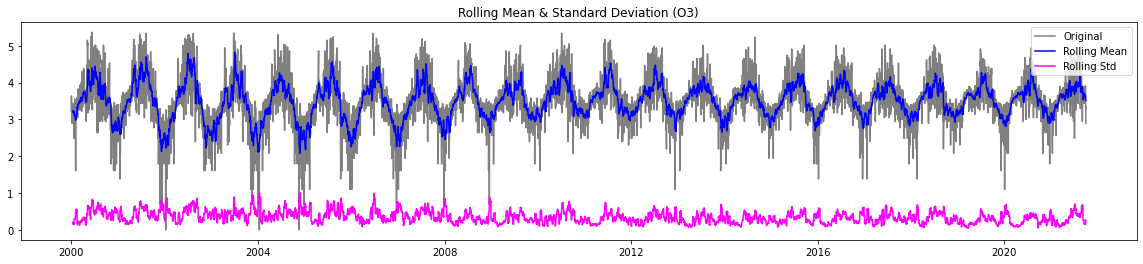

Results of Dickey-Fuller Test: 

Test Statistic           -5.808590e+00
p-value                   4.456040e-07
# of Lags Used            2.100000e+01
# of Observations Used    7.922000e+03
Critical Value (1%)      -3.431176e+00
Critical Value (5%)      -2.861905e+00
Critical Value (10%)     -2.566964e+00
dtype: float64


In [13]:
# Checking daily O3
dailyO3_log.plot(figsize=(20,4))
stationarity_check(dailyO3_log, 'O3')

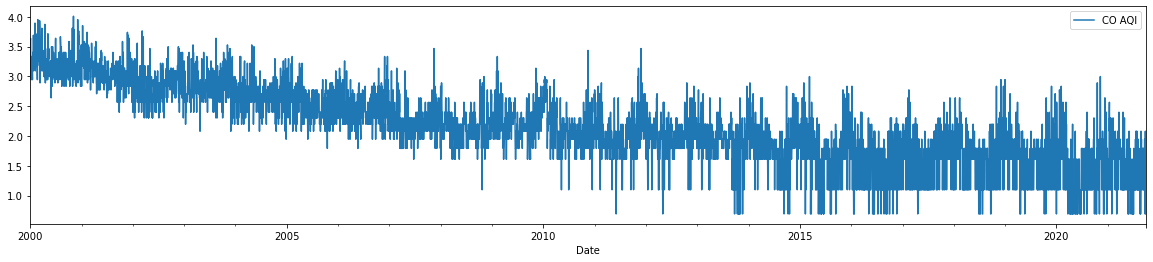

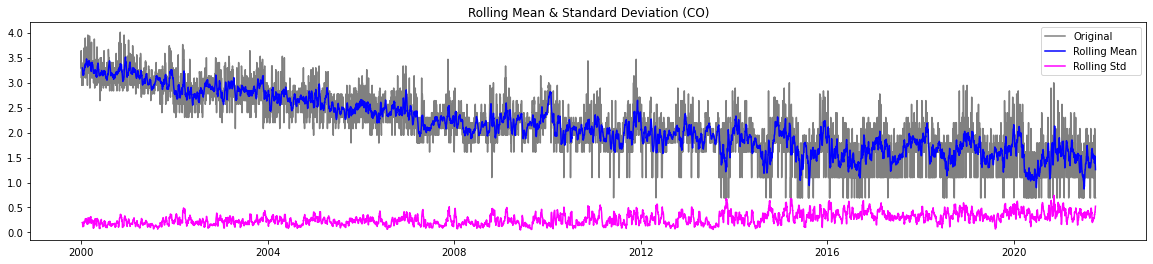

Results of Dickey-Fuller Test: 

Test Statistic              -2.705216
p-value                      0.073140
# of Lags Used              34.000000
# of Observations Used    7910.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861905
Critical Value (10%)        -2.566965
dtype: float64


In [14]:
# Checking daily CO
dailyCO_log.plot(figsize=(20,4))
stationarity_check(dailyCO_log, 'CO')

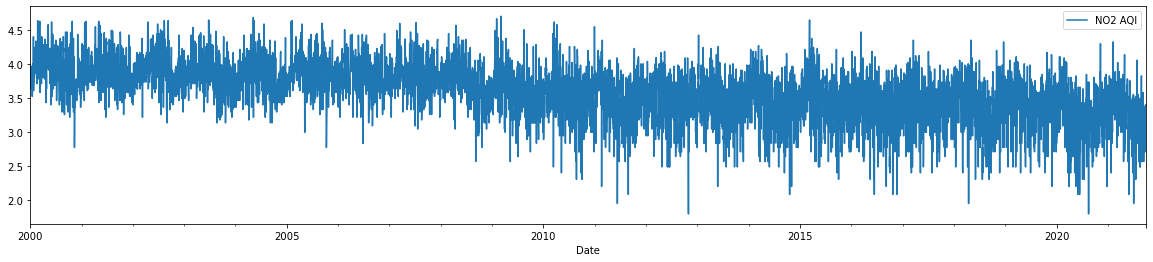

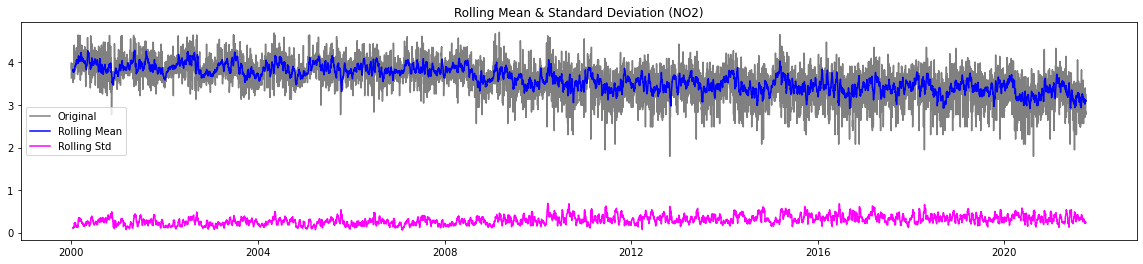

Results of Dickey-Fuller Test: 

Test Statistic              -4.165286
p-value                      0.000754
# of Lags Used              34.000000
# of Observations Used    7909.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861906
Critical Value (10%)        -2.566965
dtype: float64


In [15]:
# Checking daily NO2
dailyNO2_log.plot(figsize=(20,4))
stationarity_check(dailyNO2_log, 'NO2')

MissingDataError: exog contains inf or nans

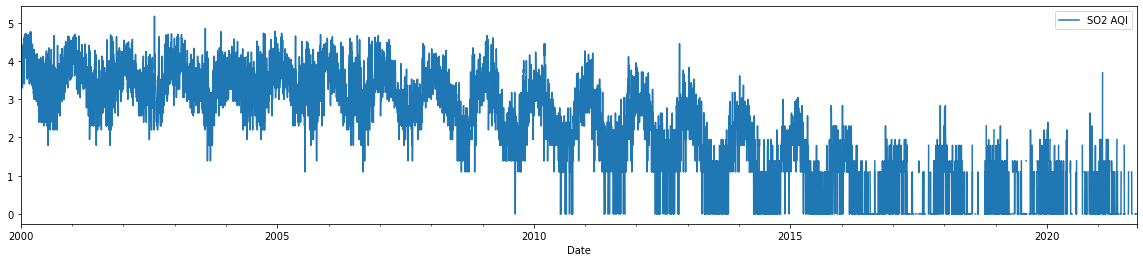

In [16]:
# Checking daily SO2
dailySO2_log.plot(figsize=(20,4))
stationarity_check(dailySO2_log, 'SO2')

In [17]:
# Monthly AQI log
monthlyO3_log = np.log(monthlyO3)
monthlyCO_log = np.log(monthlyCO)
monthlyNO2_log = np.log(monthlyNO2)
monthlySO2_log = np.log(monthlySO2)

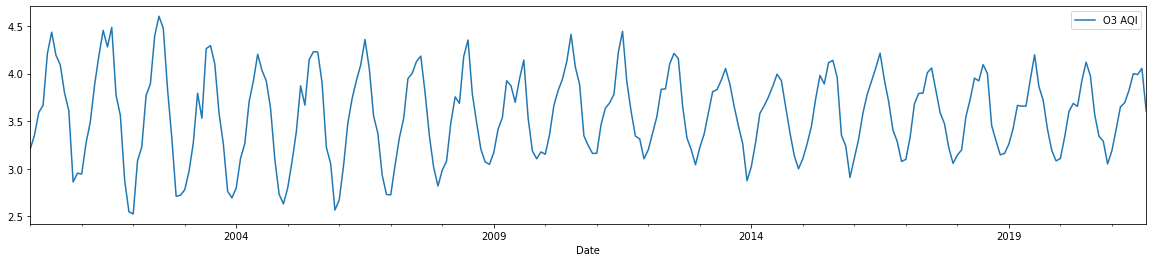

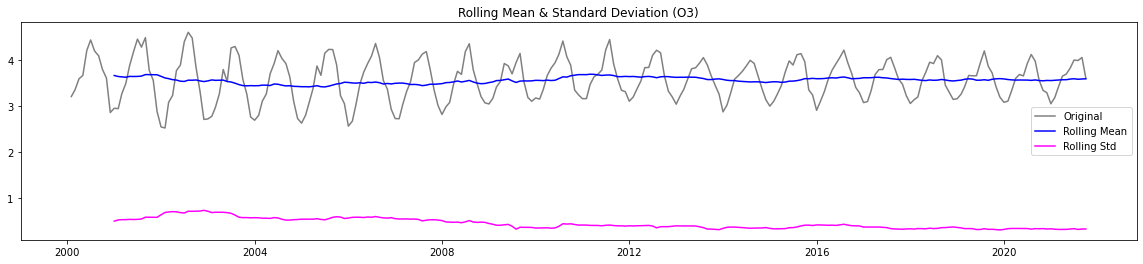

Results of Dickey-Fuller Test: 

Test Statistic             -2.153275
p-value                     0.223639
# of Lags Used             15.000000
# of Observations Used    245.000000
Critical Value (1%)        -3.457326
Critical Value (5%)        -2.873410
Critical Value (10%)       -2.573096
dtype: float64


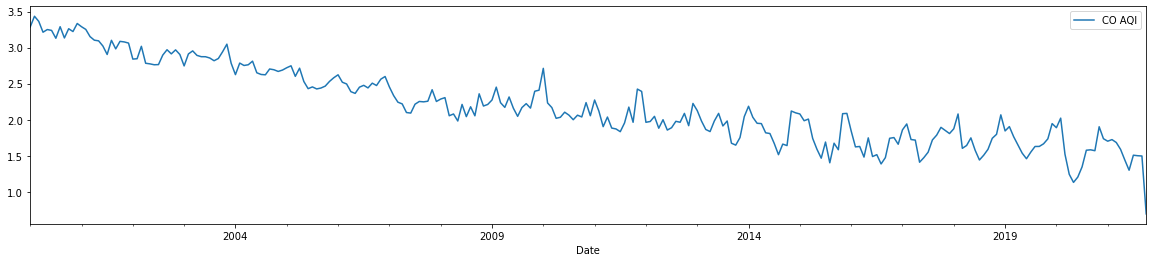

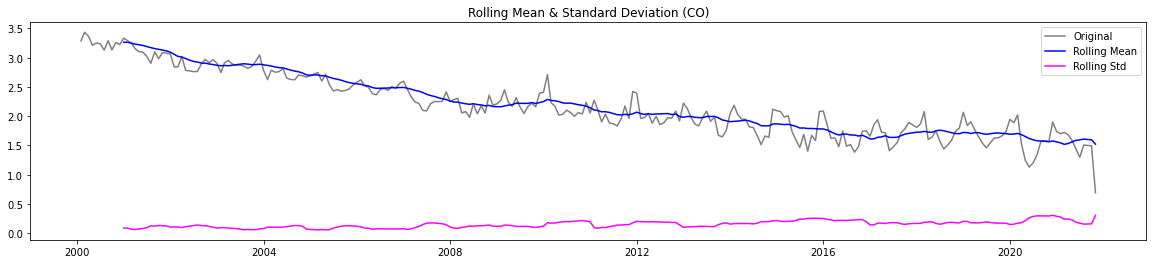

Results of Dickey-Fuller Test: 

Test Statistic             -1.904494
p-value                     0.329950
# of Lags Used             11.000000
# of Observations Used    250.000000
Critical Value (1%)        -3.456781
Critical Value (5%)        -2.873172
Critical Value (10%)       -2.572969
dtype: float64


In [18]:
# Checking monthly O3
monthlyO3_log.plot(figsize=(20,4))
stationarity_check(monthlyO3_log, 'O3')

# Checking monthly CO
monthlyCO_log.plot(figsize=(20,4))
stationarity_check(monthlyCO_log, 'CO')

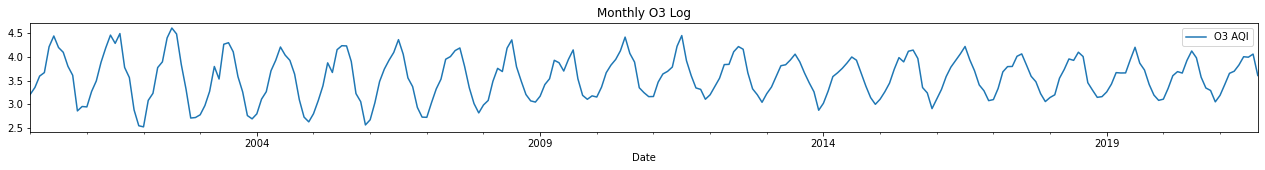

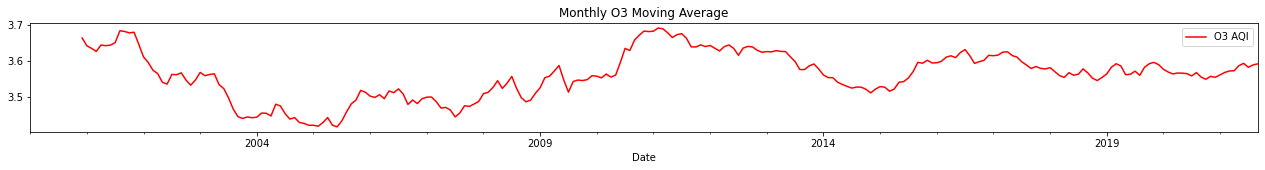

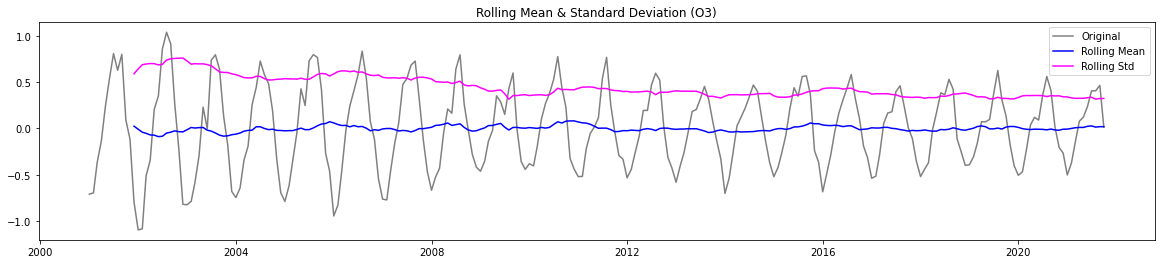

Results of Dickey-Fuller Test: 

Test Statistic             -4.894367
p-value                     0.000036
# of Lags Used             14.000000
# of Observations Used    235.000000
Critical Value (1%)        -3.458487
Critical Value (5%)        -2.873919
Critical Value (10%)       -2.573367
dtype: float64


In [19]:
# Moving average O3
moving_avg = monthlyO3_log.rolling(window=12).mean()
monthlyO3_log.plot(figsize=(22,2), title='Monthly O3 Log')
moving_avg.plot(figsize=(22,2), color='red', title='Monthly O3 Moving Average')
monthlyO3_log_moving_avg_diff = monthlyO3_log - moving_avg
monthlyO3_log_moving_avg_diff.dropna(inplace=True)

stationarity_check(monthlyO3_log_moving_avg_diff, 'O3')

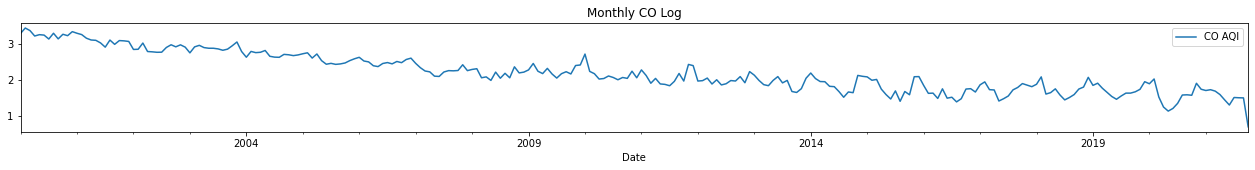

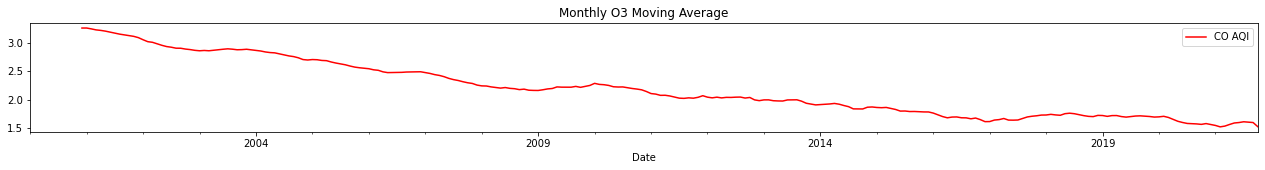

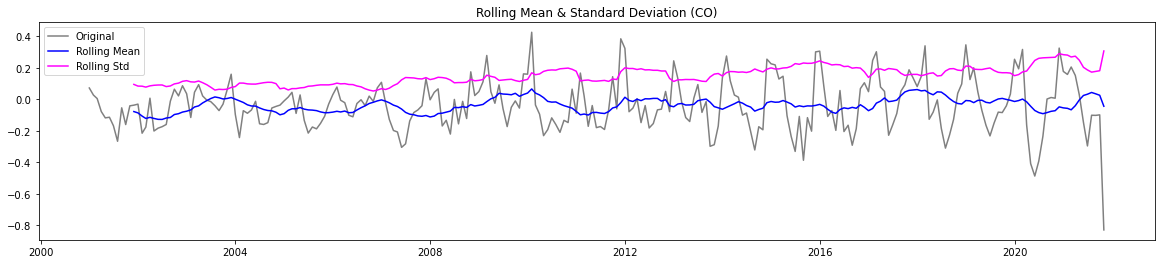

Results of Dickey-Fuller Test: 

Test Statistic             -4.266374
p-value                     0.000508
# of Lags Used             15.000000
# of Observations Used    235.000000
Critical Value (1%)        -3.458487
Critical Value (5%)        -2.873919
Critical Value (10%)       -2.573367
dtype: float64


In [20]:
# Moving average CO
moving_avg = monthlyCO_log.rolling(window=12).mean()
monthlyCO_log.plot(figsize=(22,2), title='Monthly CO Log')
moving_avg.plot(figsize=(22,2), color='red', title='Monthly O3 Moving Average')
monthlyCO_log_moving_avg_diff = monthlyCO_log - moving_avg
monthlyCO_log_moving_avg_diff.dropna(inplace=True)

stationarity_check(monthlyCO_log_moving_avg_diff, 'CO')

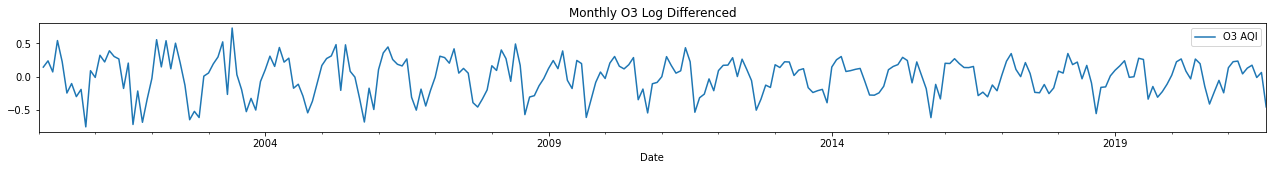

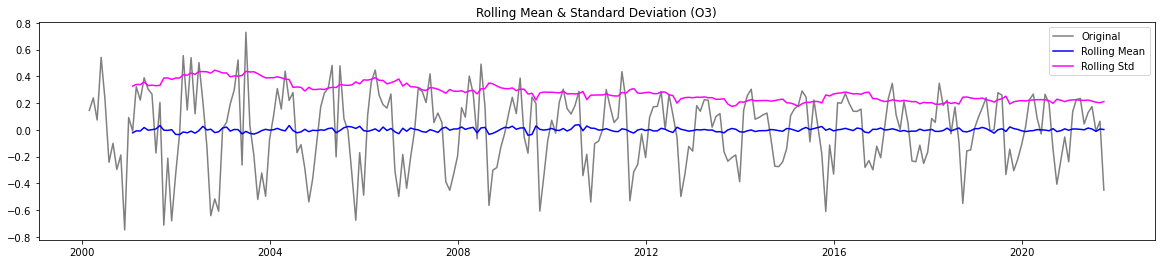

Results of Dickey-Fuller Test: 

Test Statistic           -7.267124e+00
p-value                   1.624025e-10
# of Lags Used            1.400000e+01
# of Observations Used    2.450000e+02
Critical Value (1%)      -3.457326e+00
Critical Value (5%)      -2.873410e+00
Critical Value (10%)     -2.573096e+00
dtype: float64


In [21]:
# Eliminating Trend and Seasonality
# First order differencing 
monthlyO3_log_diff = monthlyO3_log - monthlyO3_log.shift()
monthlyO3_log_diff.plot(figsize=(22,2), title='Monthly O3 Log Differenced')
monthlyO3_log_diff.dropna(inplace=True)
stationarity_check(monthlyO3_log_diff, 'O3')

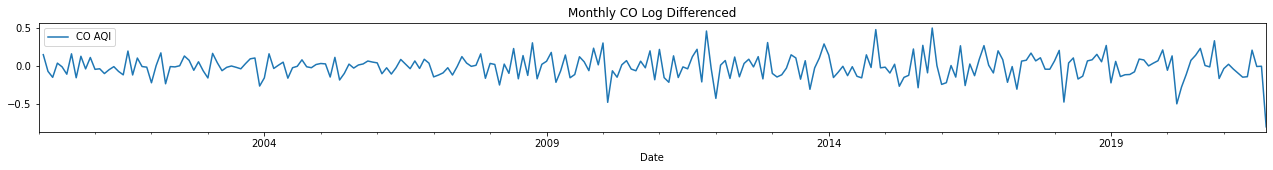

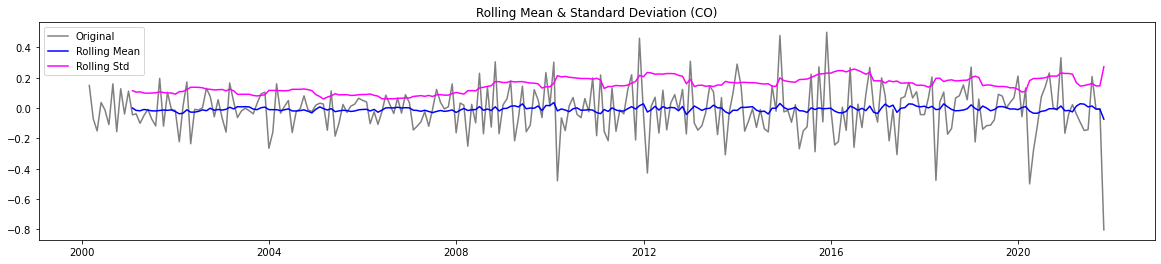

Results of Dickey-Fuller Test: 

Test Statistic           -9.216686e+00
p-value                   1.825842e-15
# of Lags Used            1.000000e+01
# of Observations Used    2.500000e+02
Critical Value (1%)      -3.456781e+00
Critical Value (5%)      -2.873172e+00
Critical Value (10%)     -2.572969e+00
dtype: float64


In [22]:
# Eliminating Trend and Seasonality
# First order differencing 
monthlyCO_log_diff = monthlyCO_log - monthlyCO_log.shift()
monthlyCO_log_diff.plot(figsize=(22,2), title='Monthly CO Log Differenced')
monthlyCO_log_diff.dropna(inplace=True)
stationarity_check(monthlyCO_log_diff, 'CO')

In [23]:
# Decompose 

# NEED TO FIX #

# monthlyCO_log_decompose = seasonal_decompose(monthlyCO_log).resid
# monthlyCO_log_decompose.dropna(inplace=True)
# stationarity_check(monthlyCO_log_decompose, 'CO')

In [24]:
# ACF and PACF
lag_acf = acf(monthlyCO_log_diff, nlags=20)
lag_pacf = pacf(monthlyCO_log_diff, nlags=20, method='ols')

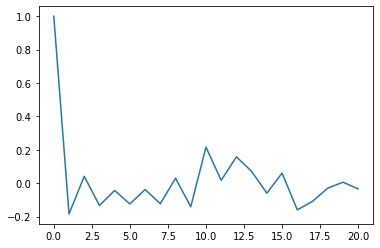

In [25]:
#Plot ACF: 
plt.plot(lag_acf)

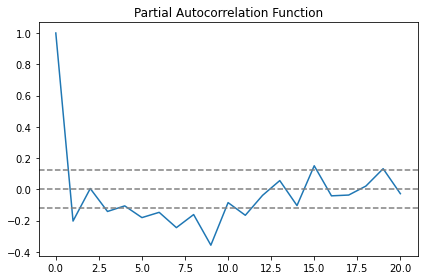

In [26]:
#Plot PACF:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(monthlyCO_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

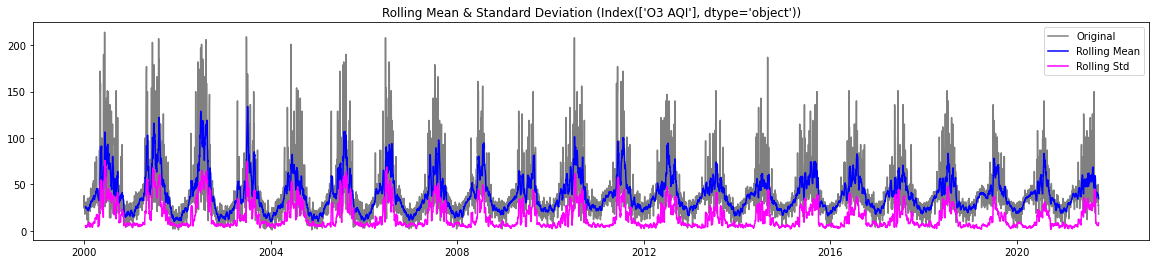

Results of Dickey-Fuller Test: 

Test Statistic           -6.420012e+00
p-value                   1.801269e-08
# of Lags Used            2.900000e+01
# of Observations Used    7.914000e+03
Critical Value (1%)      -3.431177e+00
Critical Value (5%)      -2.861905e+00
Critical Value (10%)     -2.566964e+00
dtype: float64


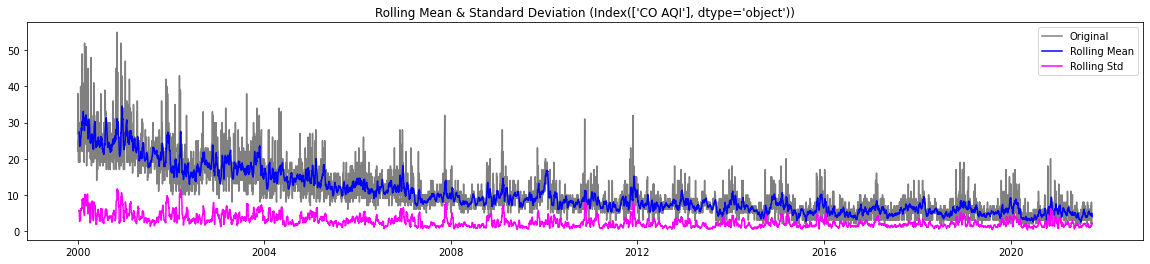

Results of Dickey-Fuller Test: 

Test Statistic              -3.077750
p-value                      0.028244
# of Lags Used              36.000000
# of Observations Used    7908.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861906
Critical Value (10%)        -2.566965
dtype: float64


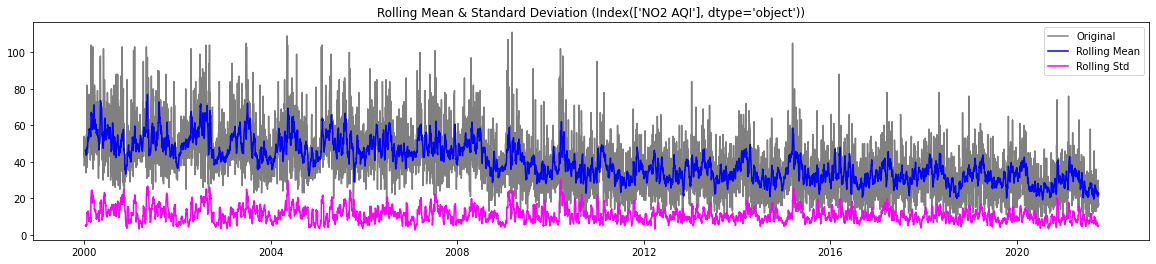

Results of Dickey-Fuller Test: 

Test Statistic              -4.521453
p-value                      0.000180
# of Lags Used              34.000000
# of Observations Used    7909.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861906
Critical Value (10%)        -2.566965
dtype: float64


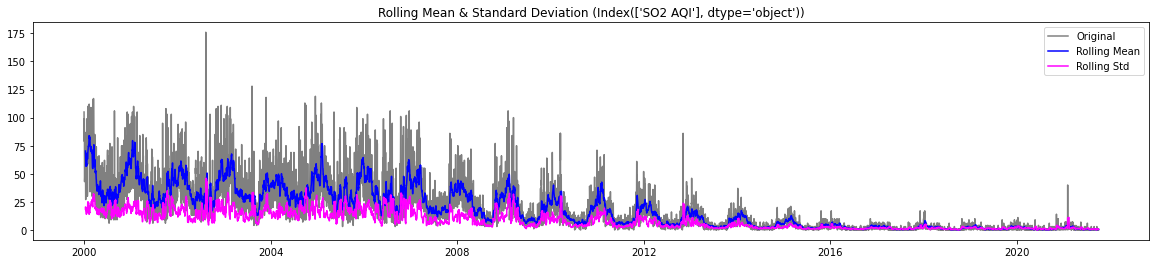

Results of Dickey-Fuller Test: 

Test Statistic              -3.791089
p-value                      0.003000
# of Lags Used              33.000000
# of Observations Used    7910.000000
Critical Value (1%)         -3.431177
Critical Value (5%)         -2.861905
Critical Value (10%)        -2.566965
dtype: float64


In [27]:
i=0
for df in dflist:
    stationarity_check(df, df.columns)
    i+=1

# <span style="font-size:1.2em;"> <a id="Modeling">Modeling</a>

In [28]:
dd= np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()


from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(rms)

RMSE = 43.9164061439

NameError: name 'train' is not defined

In [29]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))

In [30]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2],12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:1165.7600595496024
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:817.4177527431933
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-86.64817594588106
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-84.62244571807231
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-149.50231659299766
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-207.73117861563975
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-81.14731134557157
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-111.64651254482528
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:835.8363642495663
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:545.9558014087152
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-131.51176550747624
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-131.35977230637826


/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/statsmodels/base/model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-144.66314997242404
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-239.1983294266417
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-125.76222834762729
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-132.17668765654247
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-217.34903558970012
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-205.21208450205074
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-91.19641388669035
ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-177.24484602985683
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-207.71524479465364
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-204.09631758292184
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-111.69163226727395
ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-172.400988491292
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-223.07698373169364
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-215.39695743139248
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-138.94929550564348
ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-218.47898141031447
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-221.6150393409527
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC

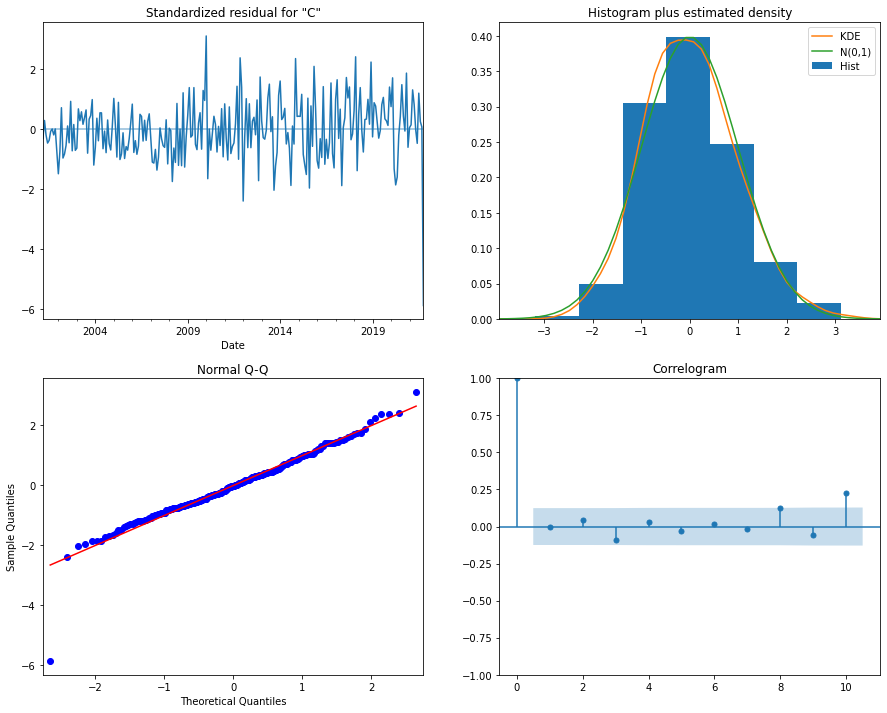

In [31]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = SARIMAX(monthlyCO_log,
                          order=param,
                          seasonal_order=param_seasonal,
                          enforce_stationarity=False,
                          enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue
        
mod = SARIMAX(monthlyCO_log,
              order=(1,0,1),
              seasonal_order=(1, 0, 1, 12),
              enforce_stationarity=False,
              enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

results.plot_diagnostics(figsize=(15, 12))
plt.show()

<Figure size 1584x432 with 0 Axes>

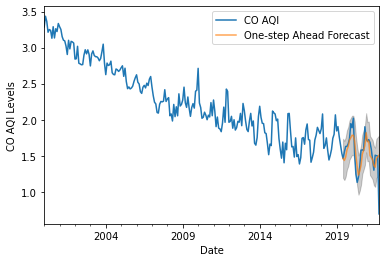

In [32]:
pred = results.get_prediction(start=pd.to_datetime('2019-06-30 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()
fig = plt.figure(figsize=(22,6))
ax = monthlyCO_log['2000':].plot(label='Observed')
pred.predicted_mean.plot(ax=ax, label='One-step Ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI Levels')
plt.legend()
plt.show()

In [33]:
monthlyCO_forecasted = np.exp(pred.predicted_mean)
monthlyCO_truth = np.exp(monthlyCO_log['2015-06-30 00:00:00':])

"""
NEED TO FIX THIS
"""

# Compute the mse and rmse
mse =( (monthlyCO_forecasted - monthlyCO_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The RMSE of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 2019-06-30 00:00:00   NaN
2019-07-31 00:00:00   NaN
2019-08-31 00:00:00   NaN
2019-09-30 00:00:00   NaN
2019-10-31 00:00:00   NaN
2019-11-30 00:00:00   NaN
2019-12-31 00:00:00   NaN
2020-01-31 00:00:00   NaN
2020-02-29 00:00:00   NaN
2020-03-31 00:00:00   NaN
2020-04-30 00:00:00   NaN
2020-05-31 00:00:00   NaN
2020-06-30 00:00:00   NaN
2020-07-31 00:00:00   NaN
2020-08-31 00:00:00   NaN
2020-09-30 00:00:00   NaN
2020-10-31 00:00:00   NaN
2020-11-30 00:00:00   NaN
2020-12-31 00:00:00   NaN
2021-01-31 00:00:00   NaN
2021-02-28 00:00:00   NaN
2021-03-31 00:00:00   NaN
2021-04-30 00:00:00   NaN
2021-05-31 00:00:00   NaN
2021-06-30 00:00:00   NaN
2021-07-31 00:00:00   NaN
2021-08-31 00:00:00   NaN
2021-09-30 00:00:00   NaN
2021-10-31 00:00:00   NaN
CO AQI                NaN
dtype: float64
The RMSE of our forecasts is 2019-06-30 00:00:00   NaN
2019-07-31 00:00:00   NaN
2019-08-31 00:00:00   NaN
2019-09-30 00:00:00   NaN
2019-10-31 00:00:00   NaN
201

In [34]:
"""
NEED TO FIX THIS
"""
MASE(monthlyCO_truth, monthlyCO_truth, monthlyCO_forecasted)

NameError: name 'MASE' is not defined

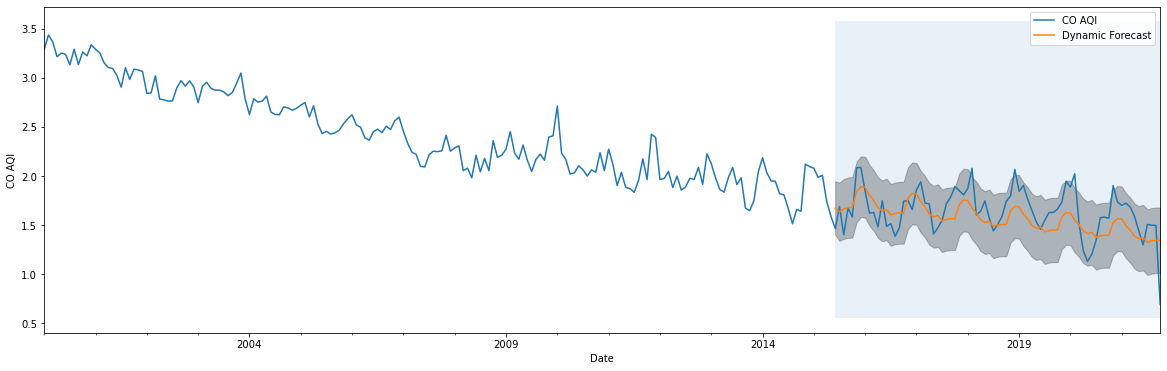

In [35]:
pred_dynamic = results.get_prediction(start=pd.to_datetime('2015-06-30 00:00:00'), dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

ax = monthlyCO_log['2000':].plot(label='Observed', figsize=(20, 6))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pd.to_datetime('2015-06-30 00:00:00'), monthlyCO_log.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')

plt.legend()
plt.show()

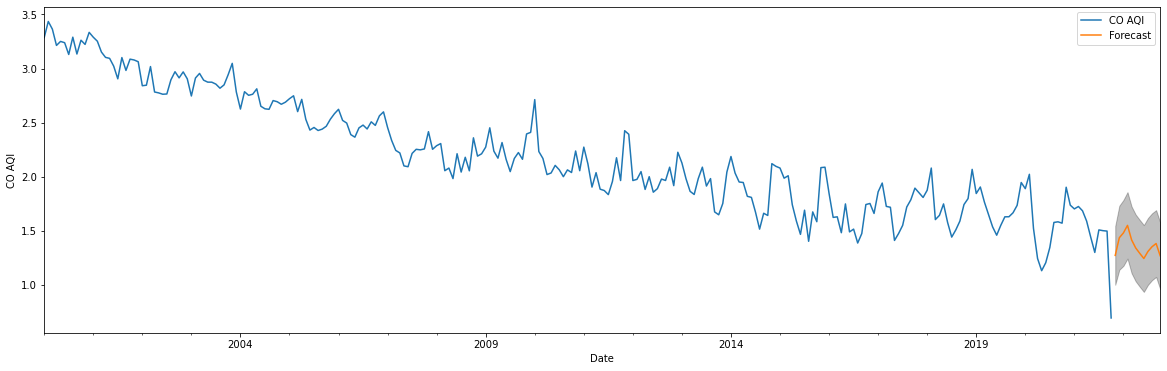

2021-11-30    3.567743
2021-12-31    4.200072
2022-01-31    4.391514
2022-02-28    4.709071
2022-03-31    4.118946
2022-04-30    3.823132
2022-05-31    3.635541
2022-06-30    3.466295
2022-07-31    3.698868
2022-08-31    3.864704
2022-09-30    3.980901
2022-10-31    3.554882
Freq: M, Name: predicted_mean, dtype: float64

In [36]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=12)

# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

ax = monthlyCO_log.plot(label='Observed', figsize=(20, 6))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('CO AQI')

plt.legend()
plt.show()


np.exp(pred_uc.predicted_mean)

In [ ]:
arma = ARMA_model(O3, 'O3')

# mod_arma = ARMA(O3, order=(1,0), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(0,1), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,0), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(0,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,1), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(1,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arma = ARMA(O3, order=(2,2), freq='D')
# O3_arma = mod_arma.fit()
# print(O3_arma.summary())

# mod_arima = ARIMA(O3, order=(1,1,1), freq='D')
# O3_arima = mod_arima.fit()
# print(O3_arima.summary())

# mod_sarimax = SARIMAX(O3, order=(1,1,1), freq='D')
# O3_sarimax = mod_sarimax.fit()
# print(O3_sarimax.summary())

# <span style="font-size:1.2em;"> <a id="Visualizations">Visualizations</a>

In [ ]:
df = pd.merge(O3, CO, how='inner', left_index=True, right_index=True)
df = pd.merge(df, NO2, how='inner', left_index=True, right_index=True)
df = pd.merge(df, SO2, how='inner', left_index=True, right_index=True)
df.info()

In [ ]:
# Creating list of daily AQI per pollutant
dailys = [df['O3 AQI'], df['CO AQI'], df['NO2 AQI'], df['SO2 AQI']]

# Downsampling from days to months
monthlyO3 = df.copy()['O3 AQI'].resample('M').mean()
monthlyCO = df.copy()['CO AQI'].resample('M').mean()
monthlyNO2 = df.copy()['NO2 AQI'].resample('M').mean()
monthlySO2 = df.copy()['SO2 AQI'].resample('M').mean()

# Creating list of monthly AQI per pollutant
monthlys = [monthlyO3, monthlyCO, monthlyNO2, monthlySO2]

In [ ]:
# Plotting daily AQI
plt.figure(figsize=(20,6), dpi=300)
dailys[0].plot(color='magenta', alpha=0.7)
dailys[1].plot(color='#61d4c1', alpha=0.7)
dailys[2].plot(color='#4527d9', alpha=0.7)
dailys[3].plot(color='#ffd500', alpha=0.7)
plt.title('Daily AQI')
plt.ylabel('AQI')
plt.legend();

In [ ]:
# Plotting monthly AQI
plt.figure(figsize=(20,6), dpi=300)
monthlys[0].plot(color='magenta')
monthlys[1].plot(color='#61d4c1')
monthlys[2].plot(color='#4527d9')
monthlys[3].plot(color='#ffd500')
plt.title('Monthly AQI')
plt.ylabel('AQI')
plt.legend();

# <span style="font-size:1.2em;"> <a id="Conclusion">Conclusion</a>

> In conclusion, my SARIMA model forecasted air quality in New York City quite well and could even be used in shaping government policy on public health. I would recommend implementing measures to decrease the presence of air pollutants, especially ozone and nitrogen dioxide, as there hasn't been much decrease from 2000.

# <span style="font-size:1.2em;"> <a id="Next Steps">Next Steps</a>

> Given more time and resources, I would like to explore beyond New York City, modeling for other cities and even seeing how cities compare to suburban or rural areas. Another pollutant I'd like to consider is particulate matter. In terms of modeling, it would be interesting to see how well a recurrent neural network would perform.

Function sources:

https://www.kaggle.com/victoraqiao/time-series-forecasting-arima-co-aqi

MASE:
https://github.com/scikit-learn/scikit-learn/issues/18685